In [1]:
# Loading and plotting images
import os
import cv2

# More Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from random import *

# Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
# x = []
# for p in train_d:
#     img = cv2.imread(TRAIN_IMAGE_DIR + p)
#     if img is not None:
#         img = img[:,:,0]
#         x.append(img)
# x = np.array(x)/255

# y = []
# for p in train_d:
#     img = cv2.imread(TRAIN_MASK_DIR + p, cv2.IMREAD_GRAYSCALE)
#     if img is not None:
#         img = img.astype(np.uint8)
#         y.append(img)
# y = np.array(y)/255

# print(x.shape, y.shape)

In [4]:
# print(f"There are {len(train_d)} images in the train folder.")

# Loading Images and Masks

In [5]:
# Define directories for loading images and masks
train_images_dir = r"C:\Users\Owner\Desktop\methane_enemy\train_images"
train_masks_dir = r"C:\Users\Owner\Desktop\methane_enemy\train_masks"
val_images_dir = r"C:\Users\Owner\Desktop\methane_enemy\val_images"
val_masks_dir = r"C:\Users\Owner\Desktop\methane_enemy\val_masks"

# Load training images and masks
train_images = []
train_masks = []
for i in range(len(os.listdir(train_images_dir))):
    image_path = os.path.join(train_images_dir, f'image_{i}.png')
    mask_path = os.path.join(train_masks_dir, f'mask_{i}.png')
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    train_images.append(image)
    train_masks.append(mask)
train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Load validation images and masks
val_images = []
val_masks = []
for i in range(len(os.listdir(val_images_dir))):
    image_path = os.path.join(val_images_dir, f'image_{i}.png')
    mask_path = os.path.join(val_masks_dir, f'mask_{i}.png')
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    val_images.append(image)
    val_masks.append(mask)
val_images = np.array(val_images)
val_masks = np.array(val_masks)

# Print the shapes of the loaded data
print('train_images shape:', train_images.shape)
print('train_masks shape:', train_masks.shape)
print('val_images shape:', val_images.shape)
print('val_masks shape:', val_masks.shape)

train_images shape: (3010, 128, 128)
train_masks shape: (3010, 128, 128)
val_images shape: (753, 128, 128)
val_masks shape: (753, 128, 128)


# Adding Channel Dimension to Images

In [6]:
x = train_images
y= train_masks
x = np.expand_dims(x, axis = 3) #EXPAND DIM OF X AND INSERT NEW AXIS @ 3 
y = np.expand_dims(y, axis = 3)

print(x.shape, y.shape)

(3010, 128, 128, 1) (3010, 128, 128, 1)


# Train/Test Split

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 666)

print(x_train.shape, x_valid.shape)

(2408, 128, 128, 1) (602, 128, 128, 1)


# Creating Model

Now create the Unet model:

In [8]:
def unet(pretrained_weights = None, input_size = (128,128,3)):

    inputs = Input(input_size)
    
    # 128
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # 128 -> 64
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # 64 -> 32
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # 32 -> 16
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Center: 16 -> 8
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # 8 -> 16
    up6 = Conv2DTranspose(256, (2,2),strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop5)
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([drop4,up6],axis=3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    # 16 -> 32
    up7 = Conv2DTranspose(128,(2,2),strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv3,up7],axis=3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    # 32 -> 64
    up8 = Conv2DTranspose(64,(2,2),strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv2,up8],axis=3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    # 64 -> 128
    up9 = Conv2DTranspose(32,(2,2),strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = BatchNormalization()(up9)
    merge9 = concatenate([conv1,up9],axis=3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

# Training the model

Compiling the model:

In [9]:
model = unet(input_size = (128,128,1))
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Finally Training the model

Other callbacks:

In [10]:
monitor = "val_accuracy"
file_model = "./model/keras_unet_gray_32.model"
early_stopping = EarlyStopping(monitor = monitor, patience = 5, verbose = 1)
model_checkpoint = ModelCheckpoint(file_model, monitor = monitor, save_best_only = True, verbose = 1)

callbacks = [early_stopping, model_checkpoint]

In [11]:
epochs = 3
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data = [x_valid, y_valid], 
                    epochs = epochs,
                    batch_size = batch_size,
                    callbacks = callbacks)

Epoch 1/3
76/76 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.9500
Epoch 1: val_accuracy improved from -inf to 0.77878, saving model to ./model\keras_unet_gray_32.model


INFO:tensorflow:Assets written to: ./model\keras_unet_gray_32.model\assets


INFO:tensorflow:Assets written to: ./model\keras_unet_gray_32.model\assets


76/76 [==============================] - 696s 9s/step - loss: 0.3118 - accuracy: 0.9500 - val_loss: 0.6035 - val_accuracy: 0.7788
Epoch 2/3
76/76 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9892
Epoch 2: val_accuracy improved from 0.77878 to 0.92022, saving model to ./model\keras_unet_gray_32.model


INFO:tensorflow:Assets written to: ./model\keras_unet_gray_32.model\assets


INFO:tensorflow:Assets written to: ./model\keras_unet_gray_32.model\assets


76/76 [==============================] - 650s 9s/step - loss: 0.1185 - accuracy: 0.9892 - val_loss: 0.2996 - val_accuracy: 0.9202
Epoch 3/3
76/76 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9885
Epoch 3: val_accuracy did not improve from 0.92022
76/76 [==============================] - 632s 8s/step - loss: 0.0734 - accuracy: 0.9885 - val_loss: 0.2668 - val_accuracy: 0.9195


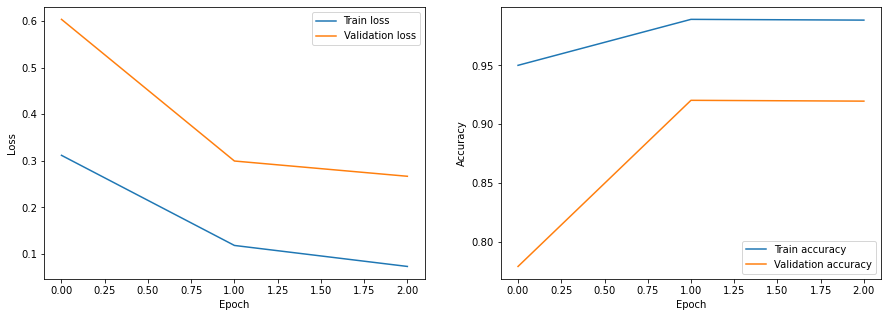

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, loss, label="Train loss")
ax_loss.plot(history.epoch, val_loss, label="Validation loss")
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.legend()
ax_acc.plot(history.epoch, acc, label="Train accuracy")
ax_acc.plot(history.epoch, val_acc, label="Validation accuracy")
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Accuracy')
ax_acc.legend()

# Making Predictions

Loading best model:

In [13]:
model = load_model(file_model)

In [14]:
preds_valid = model.predict(x_valid)
preds_valid.shape

19/19 [==============================] - 26s 1s/step


(602, 128, 128, 1)

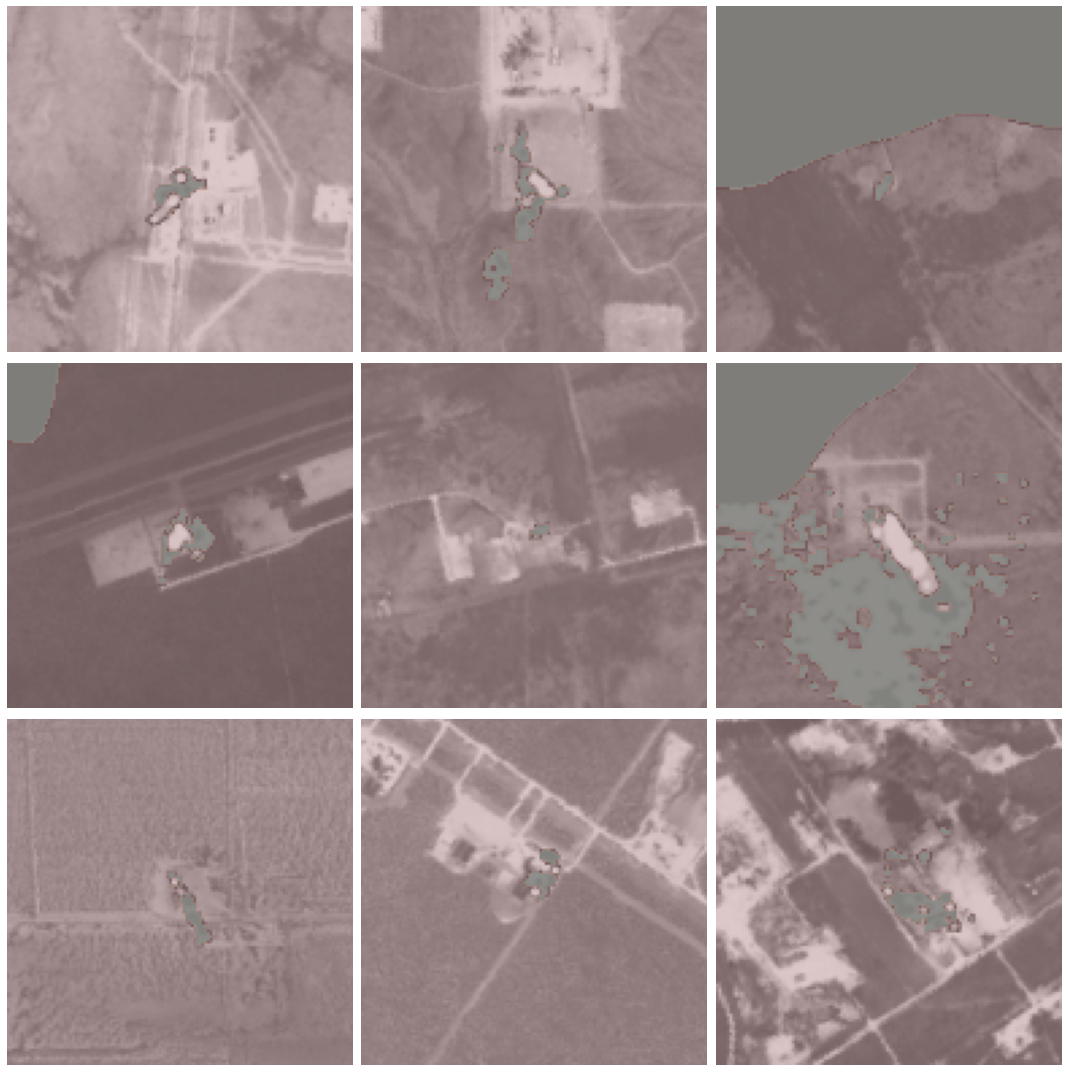

In [15]:
def plotImageTranspValid(file1, file2, file3, k, alpha1 = 0.2, alpha2 = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(15, 15))
    for i in range(k):
        for j in range(k):
            ind = randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='gray', vmin = 0, vmax = 1)
            ax[i,j].imshow(file2[ind], cmap='Reds', alpha = alpha1)
            ax[i,j].imshow(file3[ind], cmap='Greens', alpha = alpha2)
            ax[i,j].set_axis_off()

    fig.tight_layout()
    return(fig)

fig = plotImageTranspValid(x_valid[:,:,:,0], y_valid, np.round(preds_valid), k = 3, alpha1 = 0.3, alpha2 = 0.3)

# red masks is the predicted plume masks from the cnn model detection 

In [10]:
# saving the model

# serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

# Regression Modeling

In [7]:
from tensorflow.keras.models import model_from_json

# Open model

# Load the JSON file that contains the model architecture
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Load the model architecture from the JSON file
model = model_from_json(loaded_model_json)

# Load the weights from the H5 file
model.load_weights('model.h5')

In [16]:
from PIL import Image
import pandas as pd
import os
import numpy as np

In [17]:
# Load target variable
df = pd.read_csv('df.csv', index_col=0)
y = df['qplume'].values

In [18]:
x = []
for _, row in df.iterrows():
    if row['filepath']:
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        img = img / 255
        img = np.expand_dims(img, axis=2)
        x.append(img)
x = np.array(x)
df['img_arrays'] = x


In [19]:
# Generate masks
y_pred = model.predict(x)

# Add masks to dataframe
df['mask'] = pd.Series(y_pred.tolist())


95/95 [==============================] - 162s 2s/step


In [20]:
mask_pred = model.predict(x)

# Apply the mask to the test set photos
X_masked = np.copy(x)
X_masked[mask_pred < 0.5] = 0

# Combine the masked photos with the predicted labels
y_pred_masked = np.copy(y_pred)
y_pred_masked[mask_pred < 0.5] = 0

95/95 [==============================] - 170s 2s/step


In [21]:
X_masked.shape

(3021, 128, 128, 1)

In [22]:
df['y_pred_masked'] = y_pred_masked.tolist()

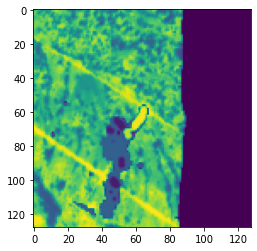

In [23]:
plt.imshow(X_masked[198])
plt.show()

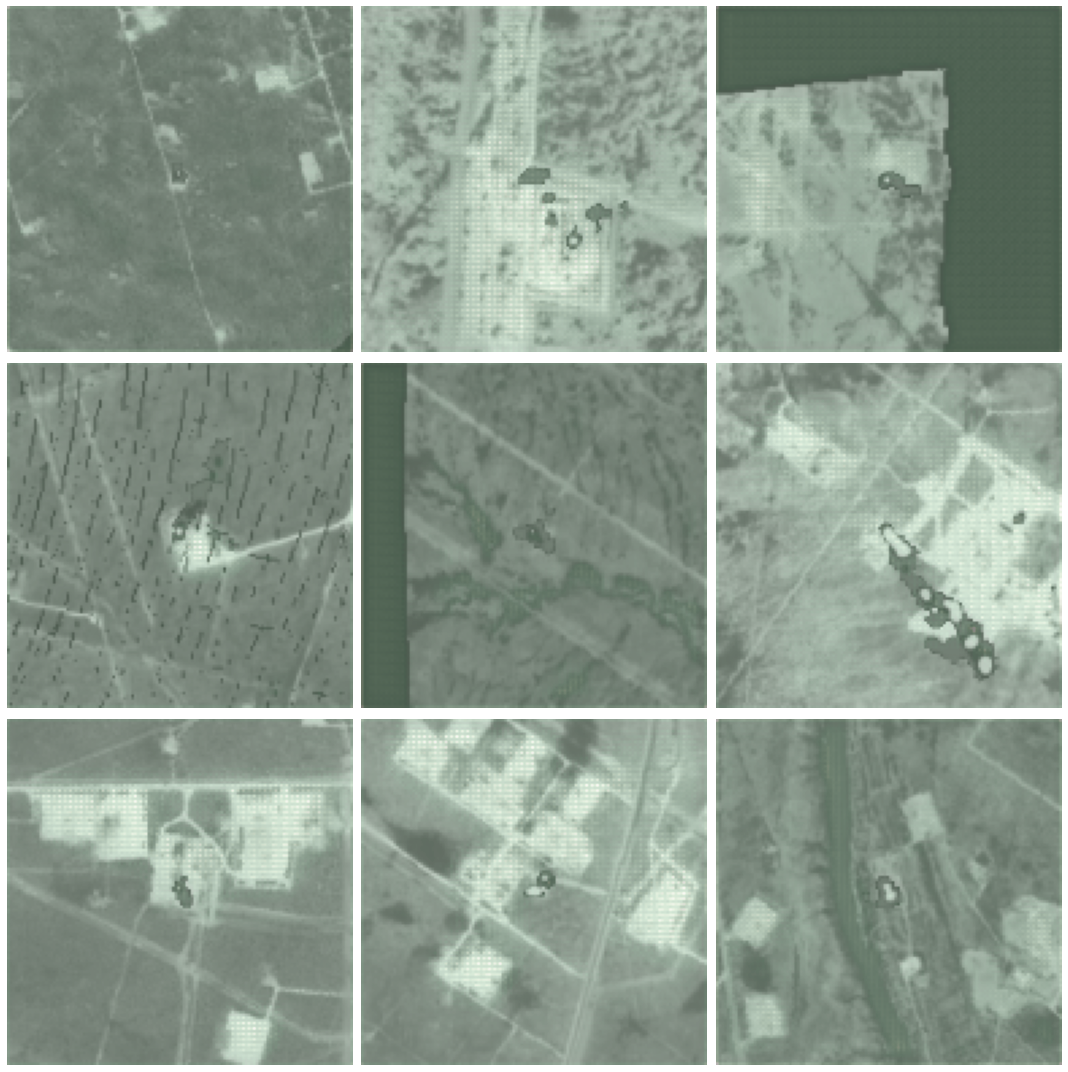

In [24]:
def plotImageTranspValid(file1, file2, file3, k, alpha1 = 0.2, alpha2 = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(15, 15))
    for i in range(k):
        for j in range(k):
            ind = randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='gray', vmin = 0, vmax = 1)
            ax[i,j].imshow(file2[ind], cmap='Greens', alpha = alpha1)
            ax[i,j].imshow(file3[ind % file3.shape[0]], cmap='Reds', alpha = alpha2)
            ax[i,j].set_axis_off()

    fig.tight_layout()
    return(fig)

fig = plotImageTranspValid(x[:,:,:,0], y_pred, np.round(y_pred), k = 3, alpha1 = 0.3, alpha2 = 0.3)

# Fitting the data to CNN Regression

In [25]:
X_masked.shape

(3021, 128, 128, 1)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

# convert X_masked into a numpy array
X = np.array(X_masked)

# extract the target variable
y = df['sigma_qplume']

# normalize the pixel values of the images
X = X / 255.0

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# create a CNN regression model
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)))
model2.add(Flatten())
model2.add(Dense(1, activation='linear'))

# compile the model
model2.compile(loss='mse', optimizer='adam')

# train the model on the training set
model2.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
76/76 [==============================] - 13s 132ms/step - loss: 61004.8750 - val_loss: 46398.2227
Epoch 2/10
76/76 [==============================] - 9s 122ms/step - loss: 53580.7578 - val_loss: 46242.8281
Epoch 3/10
76/76 [==============================] - 9s 124ms/step - loss: 53575.2305 - val_loss: 46361.6211
Epoch 4/10
76/76 [==============================] - 10s 127ms/step - loss: 53627.4727 - val_loss: 46382.1172
Epoch 5/10
76/76 [==============================] - 9s 123ms/step - loss: 53485.6055 - val_loss: 46261.9609
Epoch 6/10
76/76 [==============================] - 8s 112ms/step - loss: 53555.7461 - val_loss: 46320.7539
Epoch 7/10
76/76 [==============================] - 9s 115ms/step - loss: 53513.1484 - val_loss: 46211.9023
Epoch 8/10
76/76 [==============================] - 9s 112ms/step - loss: 53468.5898 - val_loss: 46393.0898
Epoch 9/10
76/76 [==============================] - 8s 111ms/step - loss: 53783.1836 - val_loss: 46214.3828
Epoch 10/10
76/76 [=======

In [29]:
from sklearn.metrics import mean_squared_error

# evaluate the model on the testing set
y_pred2 = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

19/19 [==============================] - 1s 29ms/step
RMSE: 216.09875666824132


In [33]:
# saving the model

# # serialize model to JSON
# model_json2 = model2.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json2)
# # serialize weights to HDF5
# model2.save_weights("model2.h5")
# print("Saved model to disk")

Saved model to disk


In [33]:
sigma_pred = model2.predict(X)
df['sigma_qplume_pred'] = sigma_pred

95/95 [==============================] - 3s 30ms/step


In [34]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [35]:
X = df['sigma_qplume_pred'].values.reshape(-1, 1)
y = df['qplume']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Training the model
xgb_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb_model.predict(X_test)

In [36]:
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)

866.8276898875793
